<a href="https://colab.research.google.com/github/gaurivn/Density-Based_Place_Clustering_Using_GeoSN_Data/blob/master/Location_Based_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=e42ebf53c2c1cad1a6928c31d01b8033518e15dae23c9a26ec863119e1a47153
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
import numpy as np 
np.random.seed(1337)

import os
datadir = './data' 
if not os.path.exists(datadir):
  os.mkdir(datadir)

url = 'https://snap.stanford.edu/data/loc-gowalla_totalCheckins.txt.gz' 
filename = os.path.join(datadir, 'loc-gowalla_totalCheckins.txt.gz')

if not os.path.isfile(filename):
  import wget
  wget.download(url, out=filename)

####**Fetch and extract the required 'text' using regex from raw data and create a new file containing venues** 

In [10]:
## Fetch The venue names [2] in New York City 
from __future__ import unicode_literals
from importlib import reload
url = 'https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/locrec/gowalla-dataset.zip' 

src_filename = os.path.join(datadir, 'gowalla-dataset.zip')
trg_filename = os.path.join(datadir, 'gowalla_venues.csv') # data/gowalla_venues.csv
import sys
if sys.version[0] == '2':
  reload(sys)
  sys.setdefaultencoding("utf-8")
#import sys  
#reload(sys)  
#sys.setdefaultencoding('utf8')

if not os.path.isfile(trg_filename):
  import shutil
  import zipfile
  import re
  
  wget.download(url, out=src_filename)
  
  #extract
  zf = zipfile.ZipFile(src_filename, 'r')
  extracted_file = zf.extract('gowalla-dataset/spots.txt', datadir)
  tmp_filename = shutil.copy(extracted_file, datadir) #extracfile -> ./data/
  tmp_filename = "data/spots.txt"
  shutil.rmtree(os.path.dirname(extracted_file))
  
  #preprocess
  regex = re.compile(r'POINT\((\-?\d+\.\d+)\s+(\-?\d+\.\d+)\)')
  
  with open(tmp_filename, "r") as src,open(trg_filename, "w") as dst:
    next(src)
    for line in src:
      dst.write(regex.sub(r'\2\t\1', line))
      
  #cleanup
  os.remove(src_filename)
  os.remove(tmp_filename)

In [12]:
# The desired output looks something like:
!head -n 5 data/gowalla_venues.csv

1391604	Conference House Park	40.5017589436	-74.2523431778
1391611	Almer G. Russell Pavilion	40.5022647413	-74.2542636395
3612422	Conference House	40.5000644614	-74.2490418254
3612431	Billop House	40.5000644614	-74.2490418254
1391499	Biddle House	40.5054829933	-74.2541456223


### Data Preparation

In [13]:
import pandas as pd
import os
datadir = './data'
filename = os.path.join(datadir, 'loc-gowalla_totalCheckins.txt.gz')

df = pd.read_csv(filename, sep='\t', header=None)
df.columns = ['uid','timestamp','lat','lon','venue_id']
df.head()

,uid,timestamp,lat,lon,venue_id
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [14]:
df.shape

(6442892, 5)

#### Filtering new york city venues
##### The Flickr API provides us with the bounding box of the city. https://www.flickr.com/places/info/2459115

##### Bounding Box: -74.2589, 40.4774, -73.7004, 40.9176 Centroid: -74.0071, 40.7146

In [15]:
lon_min, lat_min, lon_max, lat_max = -74.2589, 40.4774, -73.7004, 40.9176

df = df[ (df['lon']>lon_min) & (df['lon']<lon_max) & (df['lat']>lat_min) & (df['lat']<lat_max) ]

df.head()

,uid,timestamp,lat,lon,venue_id
10,0,2010-10-12T00:21:28Z,40.643885,-73.782806,23261
11,0,2010-10-11T20:21:20Z,40.741374,-73.988105,16907
12,0,2010-10-11T20:20:42Z,40.741388,-73.989455,12973
13,0,2010-10-11T00:06:30Z,40.724910,-73.994621,341255
14,0,2010-10-10T22:00:37Z,40.729768,-73.998535,260957


In [16]:
df.shape

(138957, 5)

#### **Parse and localize date and time: UTC -> local**

In [17]:
import pytz as tz # better alternatives -> Apache arrow or pendulum
from datetime import datetime

def parse_datetime(s):
  tzone = tz.timezone("America/New_York")
  utc = datetime.strptime(s, '%Y-%m-%dT%H:%M:%SZ')
  return tz.utc.localize(utc).astimezone(tzone)

df['ts'] = df['timestamp'].apply(lambda x: parse_datetime(x))
df = df.drop('timestamp',axis=1,errors='ignore')

df['date'] = df['ts'].astype(object).apply(lambda x: x.date())
df['time'] = df['ts'].astype(object).apply(lambda x: x.time())
#day of the week (localtime) & hour of the day (localtime)
df['wd'] = df['date'].astype(object).apply(lambda x : x.weekday())
df['d'] = df['date'].astype(object).apply(lambda x : x.day)
df['h'] = df['time'].astype(object).apply(lambda x : x.hour)
df[['ts','date','time','wd','d','h']][0:3]

,ts,date,time,wd,d,h
10,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20
11,2010-10-11 16:21:20-04:00,2010-10-11,16:21:20,0,11,16
12,2010-10-11 16:20:42-04:00,2010-10-11,16:20:42,0,11,16


#### **Loading the venues data**

In [24]:
filename = os.path.join(datadir, 'gowalla_venues.csv')

dfv = pd.read_csv(filename, sep='\t', header=None)
dfv.columns = ['venue_id','name','lat','lon']
dfv.head()

,venue_id,name,lat,lon
0,1391604,Conference House Park,40.501759,-74.252343
1,1391611,Almer G. Russell Pavilion,40.502265,-74.254264
2,3612422,Conference House,40.500064,-74.249042
3,3612431,Billop House,40.500064,-74.249042
4,1391499,Biddle House,40.505483,-74.254146


#### **Joining Events with venues on venue ID**

In [25]:
# Will ignore events not in our venue id
df_merged = pd.DataFrame.merge(df, dfv[['venue_id']], on="venue_id", how="inner")
df_merged.head()

,uid,lat,lon,venue_id,ts,date,time,wd,d,h
0,0,40.643885,-73.782806,23261,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20
1,0,40.643885,-73.782806,23261,2010-10-07 11:27:40-04:00,2010-10-07,11:27:40,3,7,11
2,5,40.643885,-73.782806,23261,2010-08-15 23:47:20-04:00,2010-08-15,23:47:20,6,15,23
3,8,40.643885,-73.782806,23261,2010-10-06 16:23:14-04:00,2010-10-06,16:23:14,2,6,16
4,15,40.643885,-73.782806,23261,2010-10-13 00:10:36-04:00,2010-10-13,00:10:36,2,13,0


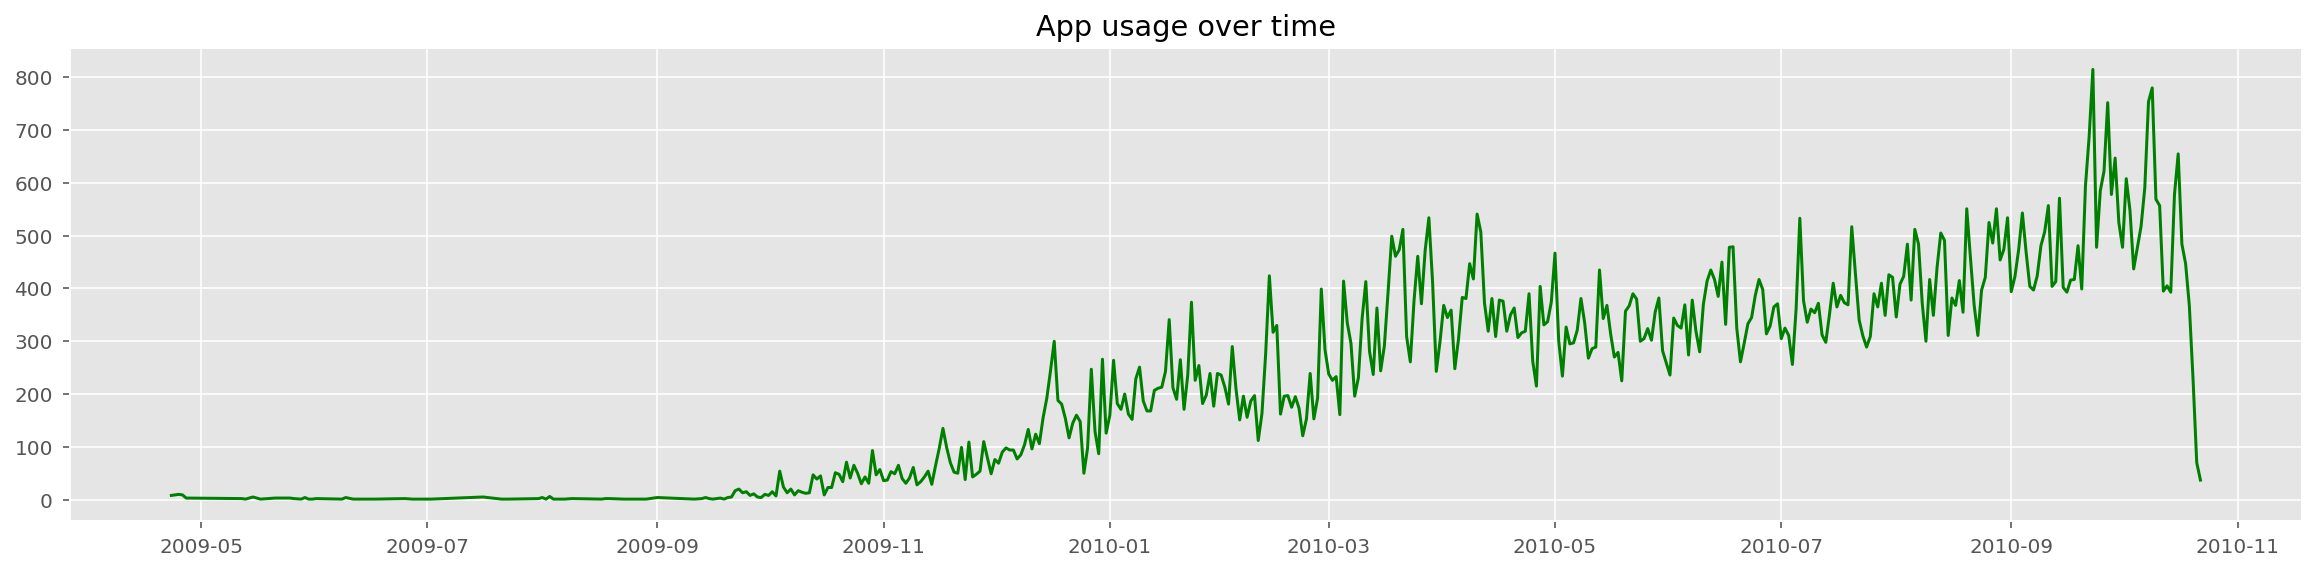

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
#import seaborn as sns
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 14})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

plt.subplot(4, 1, 1)
top = df_merged.groupby('date').size()
plt.plot(top.index, top, 'g-')
plt.title('App usage over time')
plt.show()

##### What is the distribution of events per hour of the day, per day of the week?
##### What is the histogram of the number of events registered per user?
##### Which are the most popular venues of all time?

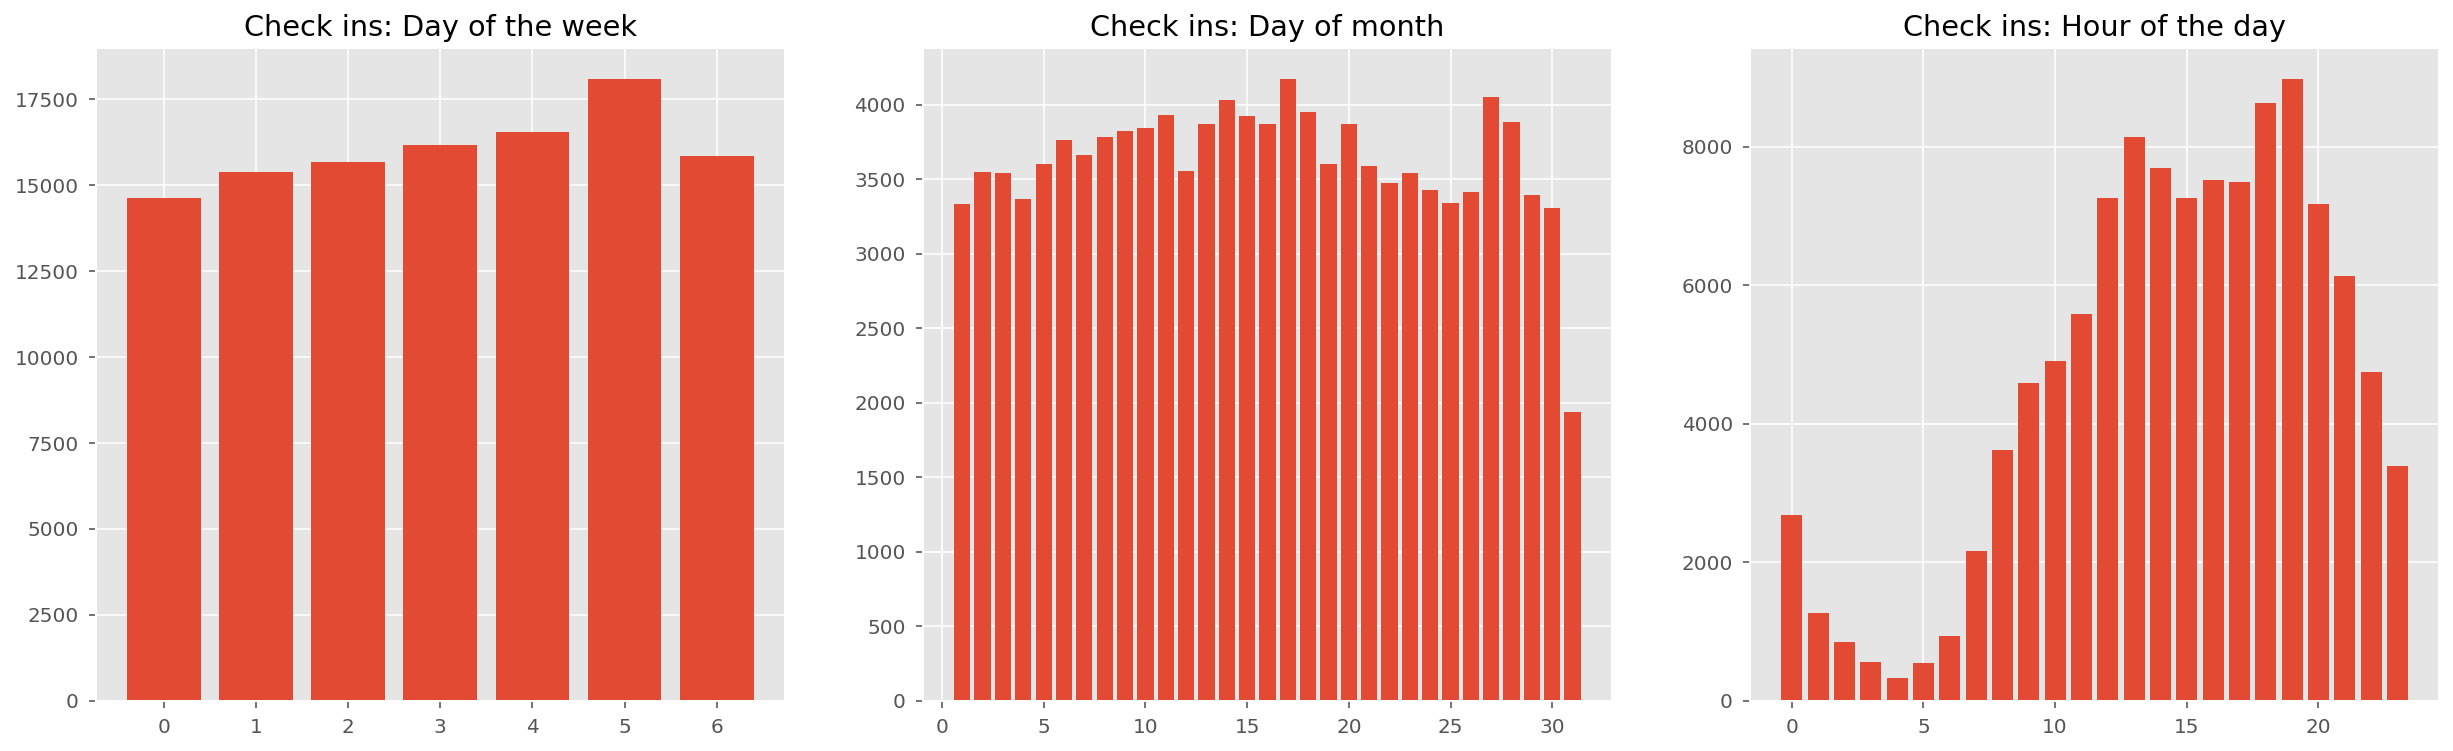

In [27]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,6)

plt.subplot(1,3,1)
events_per_hour = df_merged.groupby('wd').size()
plt.bar(events_per_hour.index, events_per_hour, align='center')
plt.title('Check ins: Day of the week')

plt.subplot(1,3,2)
day_month = df_merged.groupby('d').size()
plt.bar(day_month.index, day_month, align='center')
plt.title('Check ins: Day of month')

plt.subplot(1,3,3)
popular_venues = df_merged.groupby('h').size()
plt.bar(popular_venues.index, popular_venues, align='center')
plt.title('Check ins: Hour of the day')

plt.show()

##### The week seems to build up towards Saturday as the most popular day to record and share memorable events and venues. The end of the month has a surge of activities (most likely connected to people being happy to get their salaries). Finally, as expected, activity peaks during lunch and dinner times.

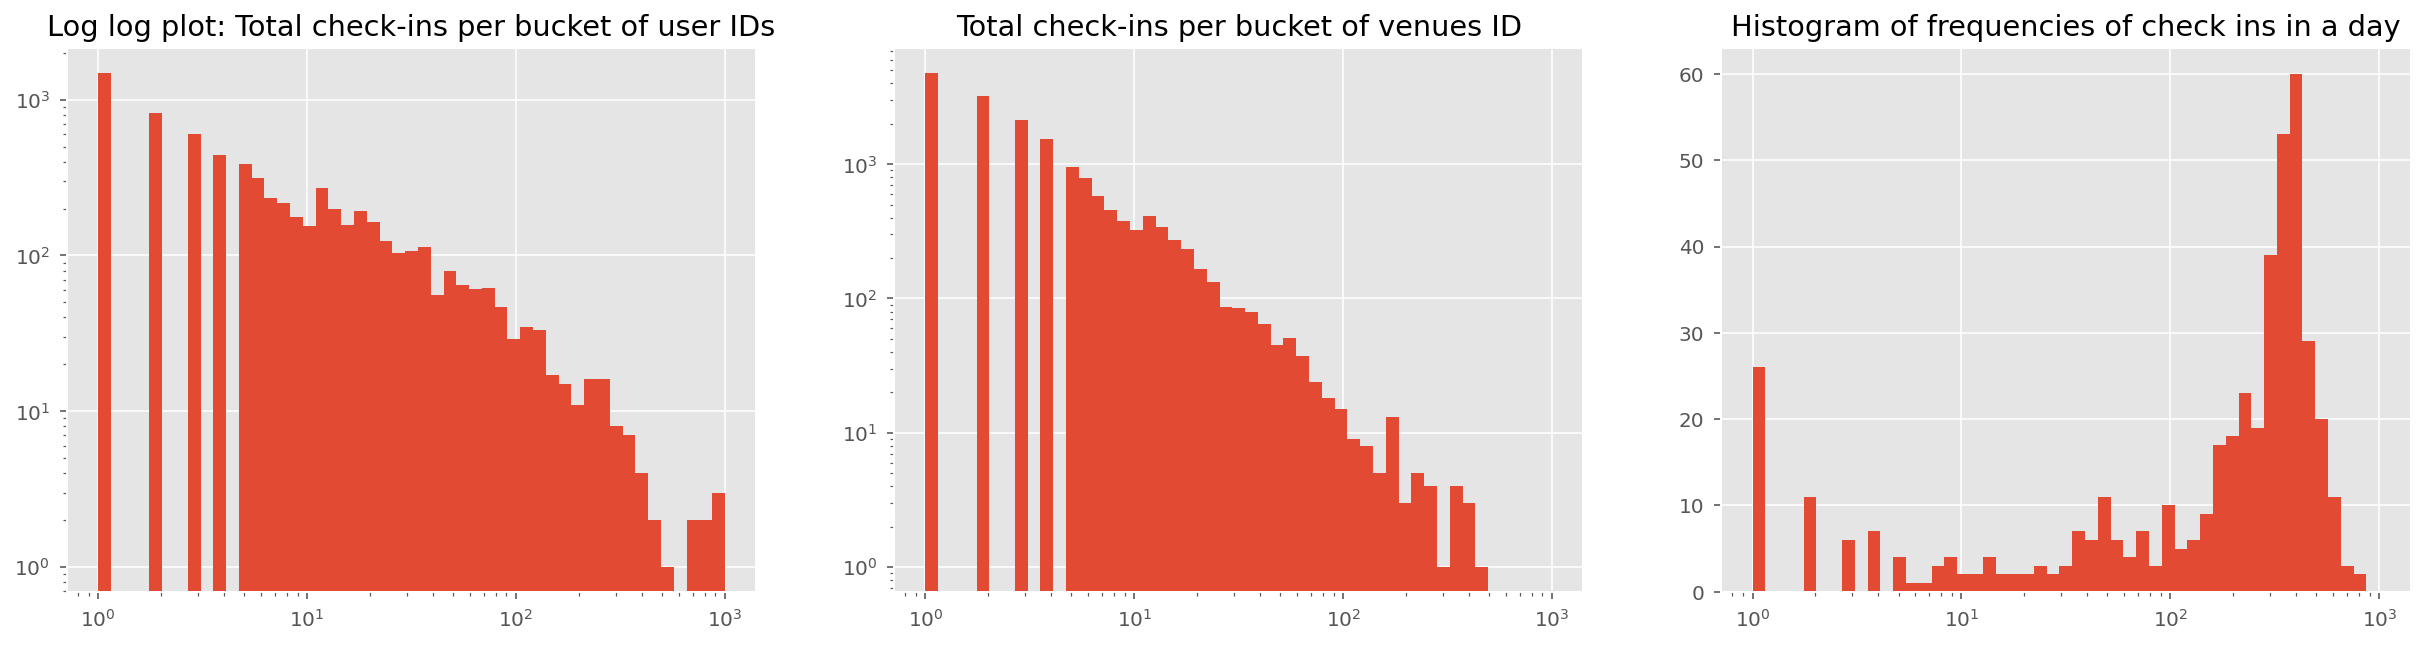

In [28]:
import numpy as np
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,5)
plt.subplot(1,3,1)
events_per_user = df_merged.groupby('uid').size()
plt.hist(events_per_user, bins=np.logspace(0,3,50))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.title('Log log plot: Total check-ins per bucket of user IDs')
plt.subplot(1,3,2)
venues = df_merged.groupby('venue_id').size()
plt.hist(venues, bins=np.logspace(0,3,50))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.title('Total check-ins per bucket of venues ID')
plt.subplot(1,3,3)
dates = df_merged.groupby('date').size()
plt.hist(dates, bins=np.logspace(0,3,50))
plt.gca().set_xscale("log")
plt.title('Histogram of frequencies of check ins in a day')
plt.show()

##### Both venues and users exhibit a zipf's law behavior, as shown above. Most of the registered users are related to small number of users and venues. The number of event registered are inversely related to the rank order. This applies to both the users as well as venues. The third histogram above shows that 60 is the most common number of events registered in a day in the city of New York

#### **Most common venues?**

In [29]:
common_venues = df_merged.groupby(['venue_id']).size()
dfv.join(common_venues.rename('count'), on='venue_id', how='inner').sort_values(by='count', ascending=False).head(10)

,venue_id,name,lat,lon,count
24140,12505,LGA LaGuardia Airport,40.774578,-73.872006,1680
5642,23261,JFK John F. Kennedy International,40.643885,-73.782806,1654
2165,24963,EWR Newark Liberty International,40.691247,-74.179516,1089
13382,11844,Times Square,40.756880,-73.986225,1089
18079,13022,Grand Central Terminal,40.752792,-73.977256,1005
9305,11875,Madison Square Garden,40.750614,-73.993435,430
19084,12525,The Museum of Modern Art (MoMA),40.761255,-73.977580,392
12880,12313,Empire State Building,40.748444,-73.985732,390
27189,11720,Yankee Stadium,40.829406,-73.927431,376
14487,11834,Bryant Park,40.753816,-73.983618,364


###### .. which makes sense. This initial analysis is a global cumulative analysis which does not take into account the fact that each area of the city has a specific dynamic. We could of course divide the city using an uniform grid, but this will not render justice to areas in Manhattan which are highly popular.

In [30]:
num_users = df_merged.groupby(['uid']).size().sort_values(ascending=False).head(10)
num_users

uid
578     1642
22      1290
842     1145
4985    1063
4902     968
4929     925
2798     919
3480     785
2964     779
1201     740
dtype: int64

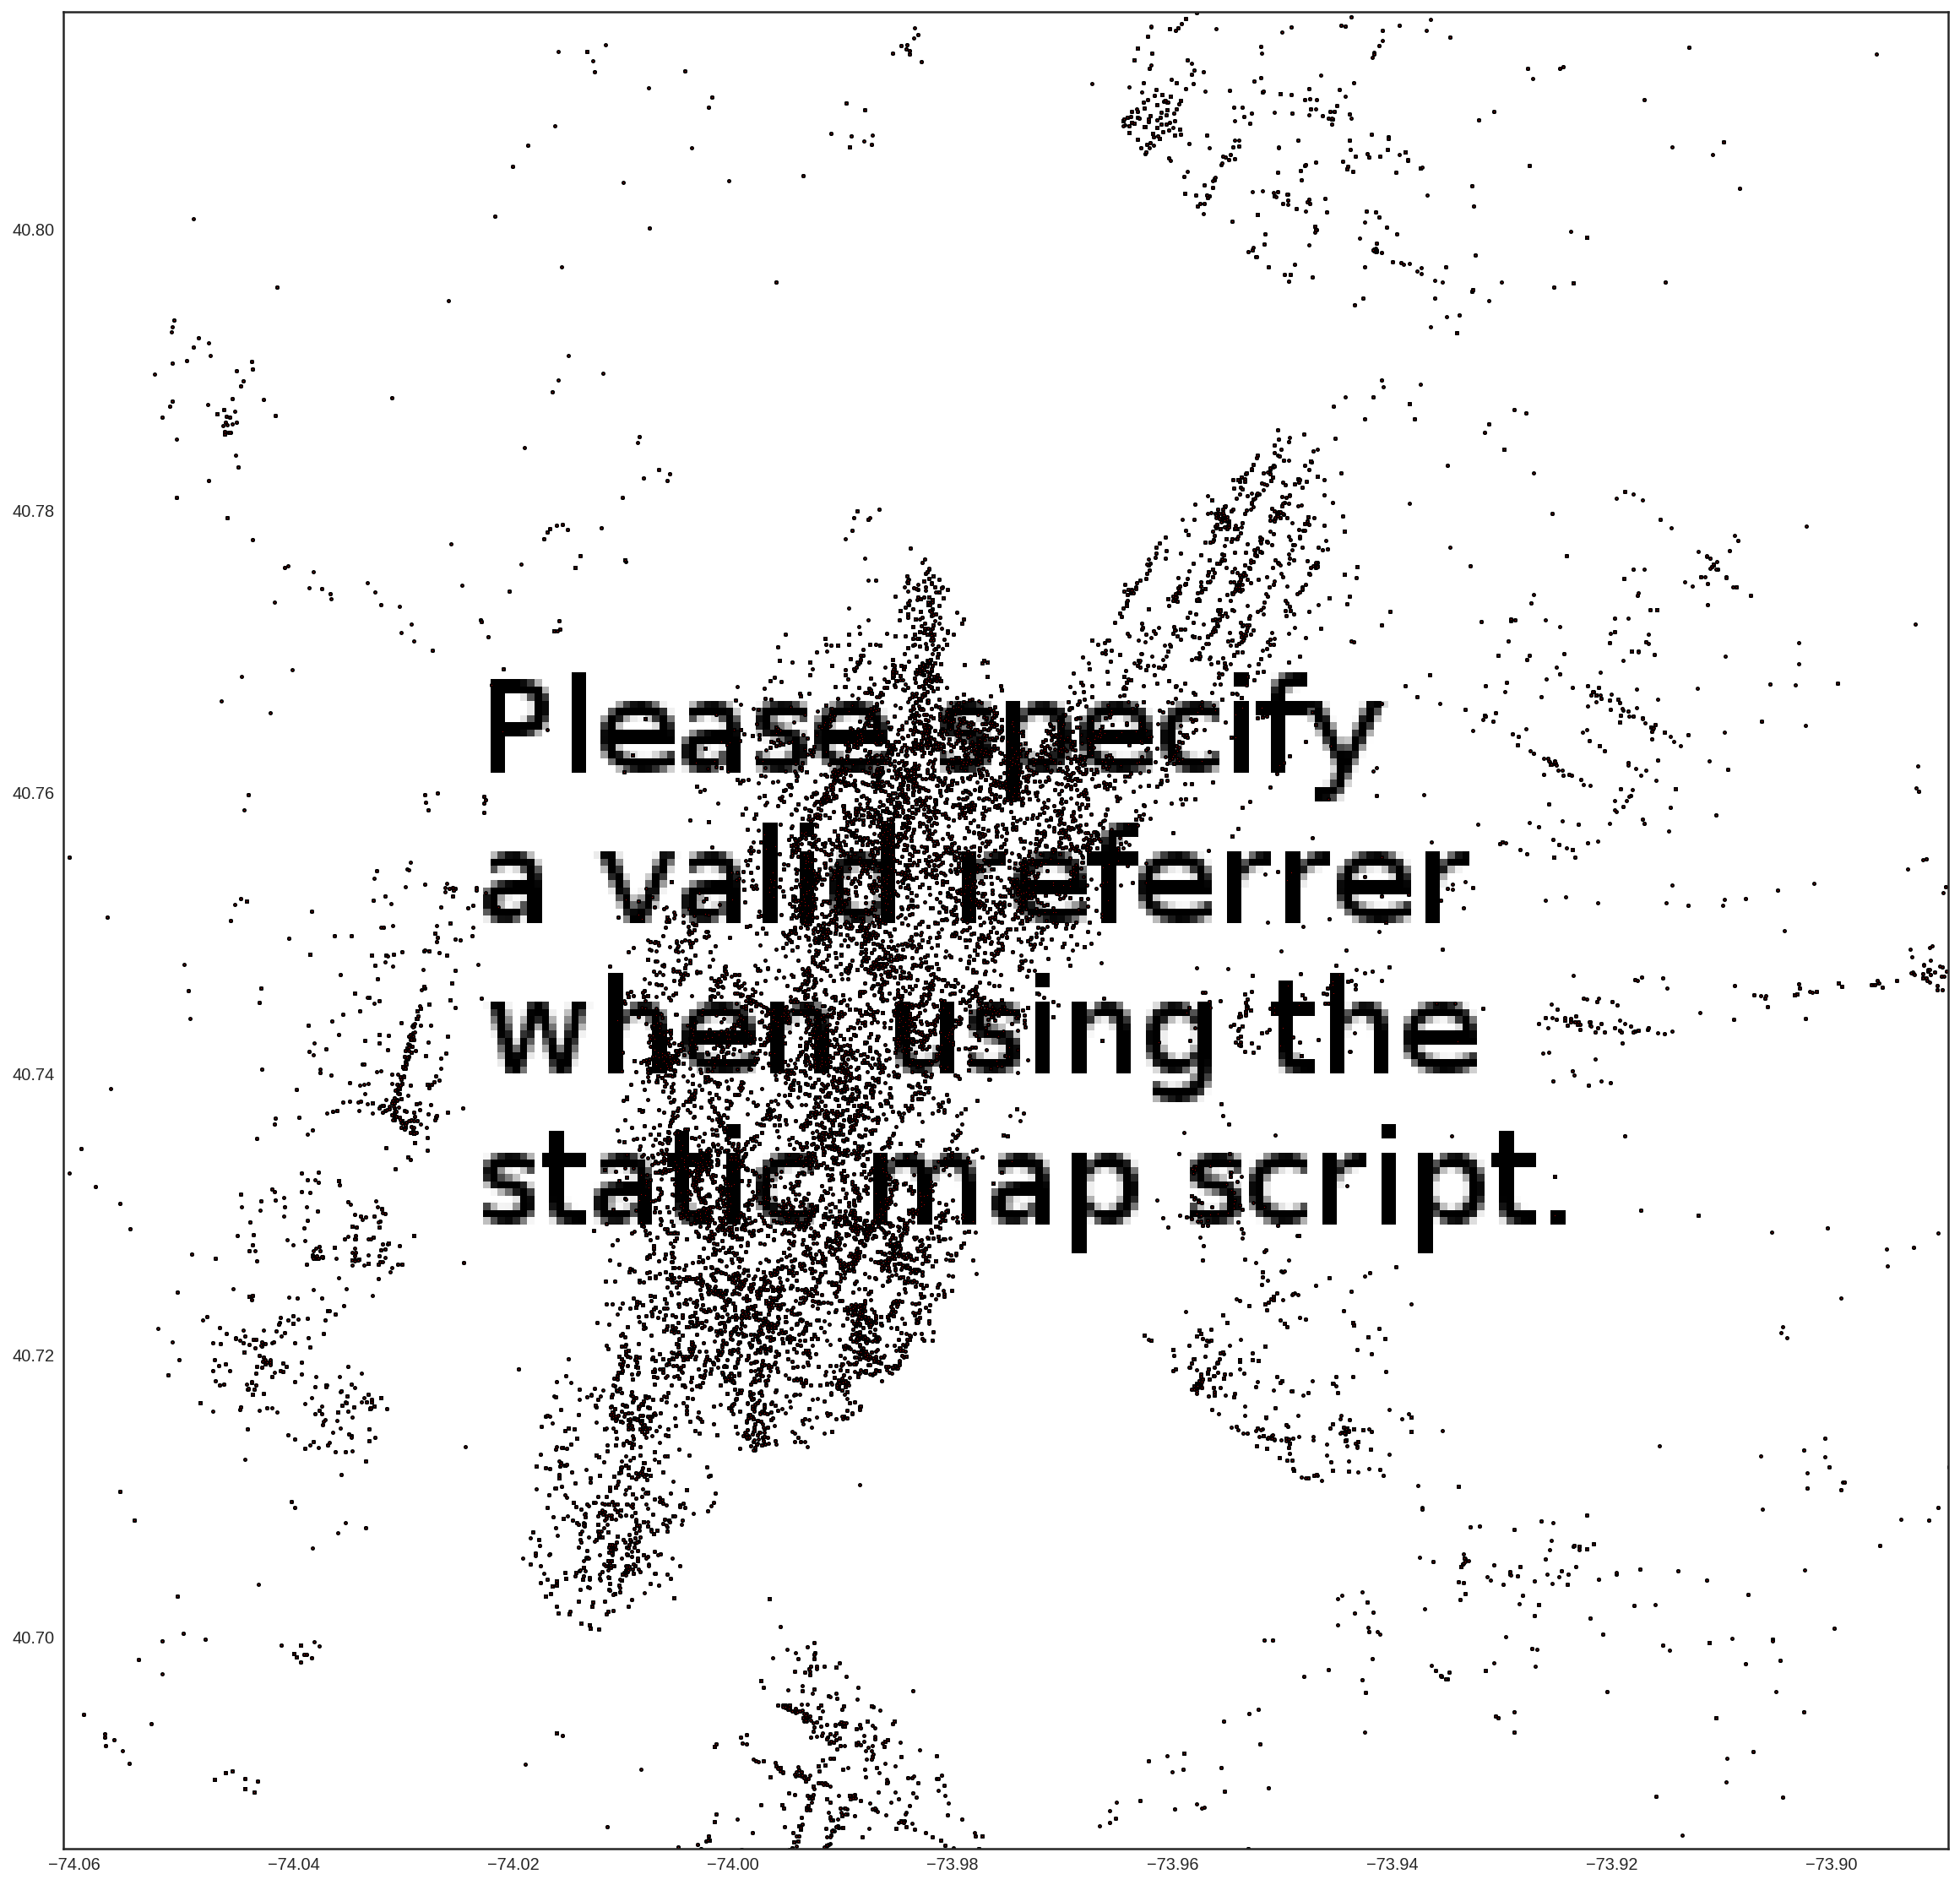

In [32]:
from PIL import Image
import urllib.request
import wget
def get_map(x,y,z,size, filename):
  static_map = "http://staticmap.openstreetmap.de/staticmap.php?center={0},{1}&zoom={2}&size={3}x{3}&maptype=mapnik".format(y,x,z,size)
  static_map_filename, headers = urllib.request.urlretrieve(static_map, filename)
  return static_map_filename

def geomap(data, zoom=13, point_size=3, point_color='r', point_alpha=1):
  #corrections to match geo with static map
  z=zoom
  picsize=1000
  wx = 1.0*360*(picsize/256)/(2**z) 
  wy = 0.76*360*(picsize/256)/(2**z) 
  
  #center of manhattan
  y = 40.7502
  x = -73.9752
  
  x_min, x_max = x-wx/2, x+wx/2
  y_min, y_max = y-wy/2, y+wy/2
  
  static_map_filename = os.path.join(datadir, 'nyc_staticmap_{}_{}.png'.format(z,picsize))
  
  if os.path.isfile(static_map_filename)==False:
    get_map(x,y,z,picsize,static_map_filename)
    
  img = Image.open(static_map_filename)
  
  #add the static map
  plt.imshow(img,zorder=0, extent=[x_min, x_max, y_min, y_max], interpolation='none', aspect='auto')
  
  #add the scatter plot of events
  plt.plot(
      data['lon'], 
      data['lat'], 
      '.', 
      markerfacecolor=point_color, 
      markeredgecolor='k', 
      markersize=point_size, 
      alpha=point_alpha)
  
  #limit the plot to the given box
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)

plt.style.use('seaborn-white')

fig = plt.figure()
fig.set_size_inches(20,20)

geomap(df_merged[['lon','lat']])

plt.show()